# The Variational Quantum Eigensolver (VQE)

VQE is a flagship algorithm for quantum chemistry. It is an application of the Ritz variational principle, where a quantum computer is trained to prepare the ground state of a given molecule.

The inputs to the VQE algorithm concise of a molecular Hamiltonian and a parameterized circuit that prepares the quantum state of the molecule. We define the cost function of the VQE as the expectation value of the Hamiltonian computed in the trial state. 

We obtain the ground state of the target Hamiltonian by performing an iterative cost minimization function. The optimization is carried out by a classical optimizer that leverages a quantum computer to evaluate the cost function and calculate its gradient at each optimization step.



## The electronic Hamiltonian
The first step is to specify and define the molecule we wish to simulate. We do this by providing a list with the symbols of the constituent atoms (for example H,H for a Hydrogen molecule) and a one-dimensional array with the corresponding nuclear coordinates in atomic units.

In [2]:
from pennylane import numpy as np

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [3]:
import pennylane as qml

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.24274501250416763) [Z2]
+ (-0.24274501250416763) [Z3]
+ (-0.04207255204071575) [I0]
+ (0.1777135823552703) [Z0]
+ (0.1777135823552704) [Z1]
+ (0.12293330446055589) [Z0 Z2]
+ (0.12293330446055589) [Z1 Z3]
+ (0.16768338851176784) [Z0 Z3]
+ (0.16768338851176784) [Z1 Z2]
+ (0.17059759275423755) [Z0 Z1]
+ (0.17627661386339277) [Z2 Z3]
+ (-0.04475008405121195) [Y0 Y1 X2 X3]
+ (-0.04475008405121195) [X0 X1 Y2 Y3]
+ (0.04475008405121195) [Y0 X1 X2 Y3]
+ (0.04475008405121195) [X0 Y1 Y2 X3]


The outputs of the function are the Hamiltonian, represented as a linear combination of Pauli operators, and the number of qubits required for the quantum simulations. 

For this example, we use a minimal basis set to represent the molecular orbitals. In this approximation, we have four spin orbitals, which defines the number of qubits. Furthermore, we use the Jordan-Wigner transformation to perform the fermionic-to-qubit mapping of the Hamiltonian.

## Implementing the VQE algorithm

In [4]:
dev = qml.device("default.qubit", wires=qubits)

Now, we definte the quantum circuit that will prepare the trial state of the molecule. We wish to prepare states of the form,

$$ |\Psi(\theta)\rangle = \cos{(\theta/2)}|1100\rangle - \sin{(\theta/2)}|0011\rangle, $$

where $\theta$ is the variational parameter to be optimized in order to find the best approximation to the true ground state. In the Jordan-Wigner encoding, the first term $|1100\rangle$ represents the state where the lowest-energy orbitals are occupied by the two electrons in the molecule. This state is also called the Hartree-Fock (HF) state.

The second term $|0011\rangle$ encodes a double excitation of the HF state where both particles are excited from quibits 0,1 to 2,3.

We will be using Givens rotations, these couple the four-qubit states $|1100\rangle$ and $|0011\rangle$, and correspond to the ```DoubleExcitation``` operation i.e., performs an $SO(2)$ roation in the two-dimensional subspace ${|1100\rangle, |0011\rangle}$. It performs the transformation

$$ |0011\rangle \rightarrow \cos{(\phi/2)}|0011\rangle + \sin{(\phi/2)}|1100\rangle $$
$$ |1100\rangle \rightarrow \cos{(\phi/2)}|1100\rangle - \sin{(\phi/2)}|0011\rangle ,$$

while leaving all the other basis states unchanged.

The quantum circuit to prepare the trial state $|\Psi(\theta)\rangle$ is implemented below using the ```hf_state()``` function to generate the vector representing the Hartree-Fock state.

In [5]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


The ```hf``` array is used by the ```BasisState``` operation to initialize the qubit register. Then, we just act with the ```DoubleExcitation``` operation on the four qubits.

In [6]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

Now we must define the cost function to compute the expectation value of the molecular Hamiltonian in the trial state prepared by the circuit. We can do so by using the ```expval()``` function. The decorator syntax allows us to run the cost function as an executable QNode with the gate parameter $\theta$:

In [7]:
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

We can now proceed to minimize the cost function and thus find the ground state of the Hydrogen molecule ($\text{H}_2$). First, we need to define the classical optmize, we will use a basic gradient-descent optimizer.

In [8]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

We can initialize the circuit parameter $\theta$ to 0 so that we start from the Hartree-Fock state.

In [9]:
theta = np.array(0.0, requires_grad=True)

We carry out this optimization over a maximum of 100 steps and aim to reach a convergence tolerance of $10^{-6}$ for the value of the cost function.

In [10]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


Now we can plot the values of the ground state energy of the molecule and the gate parameter $\theta$ as a function of the optimization step.

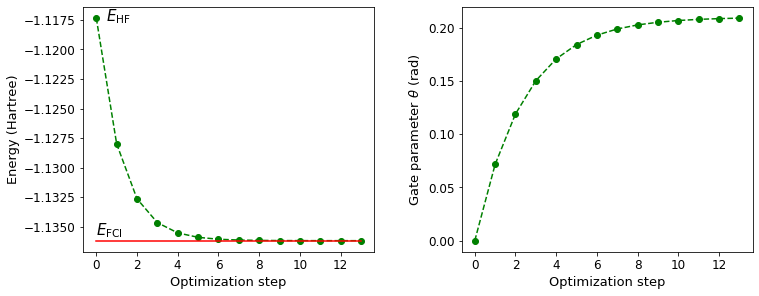

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

Thus we can observe that the VQE algorithm has converged after 13 iterations. The optimal value of the circuit parameter $\theta*=0.208$ defines the state as

$$ |\Psi(\theta*)\rangle = 0.994|1100\rangle - 0.104 |0011\rangle,$$

which is precisely the ground state of the $\text{H}_2$ molecule in a minimal basis set approximation.

## Conclusion

We have implemented the VQE algorithm to find the ground state of the hydrogen molecule. We used a simple circuit to prepare quantum states of the molecule beyond the Hartree-Fock approximation. The ground-state energy was obtained by minimizing a cost function defined as the expectation value of the molecular Hamiltonian in the trial state.

#Another (slightly more involved) example

Let us now apply the same approach to a $\text{He-H}^{+}$ molecule as has been done in the paper I have chosen.

In [ ]:
from pennylane import numpy as np

symbols = ["H", "He"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

